In [159]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from joblib import Parallel,delayed

In [126]:
path = '../data/data_emas_all_duration_day_v11.p'
data1 = pickle.load(open(path,'rb'))

In [127]:
import numpy as np
import pylab as pb
import GPy 
%pylab inline
def get_predictions(X,Y,error):
    X = (X - np.mean(X))/np.std(X)
    mm = np.mean(Y)
    ss = np.std(Y)
    Y = (Y-np.mean(Y))/ss
    kern =  GPy.kern.RBF(input_dim=1)
    Y_meta = {'output_index':np.arange(len(Y))[:,None]}
    m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
    m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    m.optimize()
    preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
    return preds*ss+mm,varss



def get_data(data):
    final_data = []
    df = pd.DataFrame({'duration':data[0],'data':data[1],'ema':data[2],'user':data[3],'hand':data[4]})

    from scipy.stats import iqr
    def get_weighted_rr_features(a):
#         f = np.percentile(a[:len(a)//2,0],80)/np.percentile(a[(len(a)//2):,0],80)
#         a = np.repeat(a[:,0],np.int64(np.round(1000*a[:,1])))
        a = a[:,0]
        return np.array([np.mean(a),
                        np.median(a),
                        np.percentile(a,80)])
#                         np.percentile(a,20),
#                         np.percentile(a,70),
#                         np.percentile(a,30),
#                         np.percentile(a,60),
#                         np.percentile(a,40),
#                         np.percentile(a,90),
#                         np.percentile(a,10)])
    
#     def get_feature1(a):
# #         try:
#         a = a[['time','stress_likelihood_ppg_qual','quality_mag']].dropna()
#         if a.shape[0]<5:
#             return np.nan
#         preds = get_predictions(a['time'].values,a['stress_likelihood_ppg_qual'].values,(1-a['quality_mag'].values)/6)
#         a['stress_likelihood_ppg_qual_final'] = preds[0]
#         plt.plot(a['time'],preds[0])
#         plt.show()
#         return a
#         except:
#             return np.nan
    
#     def get_feature(a):
#         try:
# #             print(a.columns)
#             a = a[['stress_likelihood_ppg_no_norm_qual','quality_mag']].dropna().values
            
#             return get_weighted_rr_features(a)
#         except:
#             return np.nan
        
    def get_feature(a,f='stress_likelihood_ppg_qual'):
        try:
#             print(a.columns)
            a = a[[f,'quality_mag']].dropna().values
            
            return get_weighted_rr_features(a)
        except:
            return np.nan
        
    
    def get_quality(a):
        try:
            a = a['quality_mag'].dropna().values
            return np.percentile(a,80)
        except:
            return np.nan

    for i,data2 in list(df.groupby('user',as_index=False)):
        data2['Quality Weighted, Reduced Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual_weighted'))
        data2['Quality Weighted, All Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual_all_features_weighted'))
        data2['Not Quality Weighted, Reduced Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual_weighted'))
        data2['Not Quality Weighted, All Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual_all_features_weighted'))
        data2['happy'] = data2['ema'].apply(lambda a:a['happy'])
        data2['joyful'] = data2['ema'].apply(lambda a:a['joyful'])
        data2['nervous'] = data2['ema'].apply(lambda a:a['nervous'])
        data2['sad'] = data2['ema'].apply(lambda a:a['sad'])
        data2['angry'] = data2['ema'].apply(lambda a:a['angry'])
        data2['score'] = data2['ema'].apply(lambda a:a['score'])
        data2['label'] = data2['ema'].apply(lambda a:a['label'])
        data2['probs_mean'] = data2['data'].apply(lambda a:np.mean(np.repeat(a['quality_mag'],np.round(100*a['quality_mag']))))
        data2['probs_20'] = data2['data'].apply(lambda a:np.percentile(a['quality_mag'],50))
        data2['probs_80'] = data2['data'].apply(lambda a:np.percentile(a['quality_mag'],50))
        data2['quality'] = data2['data'].apply(lambda a:get_quality(a))
        
        data2 = data2[['duration','user','quality','hand','score',
                       'happy','joyful','nervous','sad','angry',
                       'label','data','probs_mean','probs_80','probs_20',
                       'Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']].dropna()
        final_data.append(data2)
    return final_data
output = Parallel(n_jobs=30,verbose=3)(delayed(get_data)(data) for data in data1)
# output = [get_data(data) for data in data1[:1]]
final_data = []
for r in output:
    final_data.extend(r)

Populating the interactive namespace from numpy and matplotlib


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  23 | elapsed:   17.3s remaining:  1.4min
[Parallel(n_jobs=30)]: Done  12 out of  23 | elapsed:   25.3s remaining:   23.2s
[Parallel(n_jobs=30)]: Done  20 out of  23 | elapsed:   33.3s remaining:    5.0s
[Parallel(n_jobs=30)]: Done  23 out of  23 | elapsed:   35.8s finished


In [128]:
data = pd.concat(final_data)
def get_labels(df):
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
#     if np.sum(df['label'])<3:
#         return pd.DataFrame([],columns=df.columns)
#     if len(np.unique(df['label'].values))<2:
#         return pd.DataFrame([],columns=df.columns)
    return df
data_global = data.groupby(['user','duration'],as_index=False).apply(get_labels)

In [129]:
data = data_global
pickle.dump(data,open('temp_specific.p','wb'))

In [130]:
import pickle
data = pickle.load(open('temp_specific.p','rb')).reset_index(drop=True)
data.head()

,duration,user,quality,hand,score,happy,joyful,nervous,sad,angry,label,data,probs_mean,probs_80,probs_20,"Quality Weighted, Reduced Features","Quality Weighted, All Features","Not Quality Weighted, Reduced Features","Not Quality Weighted, All Features"
0,10,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,0.655053,left,1.2,1.0,2.0,1.0,1.0,1.0,0,stress_likelihood_ppg_qual stress_likeliho...,0.592843,0.652075,0.652075,"[0.24743321543094413, 0.25570048668777257, 0.2...","[0.26335169264544095, 0.2705466162044168, 0.27...","[0.10626644848018342, 0.0936513576723187, 0.11...","[0.10626644848018342, 0.0936513576723187, 0.11..."
1,10,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,0.883207,left,1.2,1.0,2.0,1.0,1.0,1.0,0,stress_likelihood_ppg_qual stress_likeliho...,0.744297,0.668277,0.668277,"[0.1275068926795074, 0.06961281112651634, 0.22...","[0.11421302809136036, 0.06259882763831105, 0.2...","[0.22315354359761325, 0.24203305243127166, 0.2...","[0.22315354359761325, 0.24203305243127166, 0.2..."
2,10,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,0.655053,left,1.2,1.0,2.0,1.0,1.0,1.0,0,stress_likelihood_ppg_qual stress_likeliho...,0.592843,0.652075,0.652075,"[0.24743321543094413, 0.25570048668777257, 0.2...","[0.26335169264544095, 0.2705466162044168, 0.27...","[0.10626644848018342, 0.0936513576723187, 0.11...","[0.10626644848018342, 0.0936513576723187, 0.11..."
3,10,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,0.361319,left,1.4,2.0,2.0,1.0,1.0,1.0,0,stress_likelihood_ppg_qual stress_likeliho...,0.330622,0.291574,0.291574,"[0.4593117357391291, 0.4650203325774641, 0.503...","[0.470567242748373, 0.4687896337803007, 0.5237...","[0.6887037556693801, 0.7182704797567272, 0.721...","[0.6887037556693801, 0.7182704797567272, 0.721..."
4,10,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,0.671490,left,1.4,2.0,2.0,1.0,1.0,1.0,0,stress_likelihood_ppg_qual stress_likeliho...,0.590730,0.577948,0.577948,"[0.08326590464406565, 0.08815476145129267, 0.0...","[0.07814806516313941, 0.07869598792991297, 0.0...","[0.20879215578332574, 0.22046840052010486, 0.2...","[0.20879215578332574, 0.22046840052010486, 0.2..."


In [131]:
data.user.unique().shape

(29,)

In [132]:
import warnings
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score,accuracy_score,auc,classification_report,make_scorer,roc_curve,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV, StratifiedKFold
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import pearsonr
from joblib import Parallel,delayed
import numpy as np
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score


def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    bias = 2
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1 and np.abs(precision[i]-recall[i])<.2:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def f1Bias_scorer_CV_2(probs, y, ret_bias=False):
    fpr, tpr, thresholds = roc_curve(y, probs)
    f1 = 0.0
    bias = 0
    for i in range(0, len(thresholds)):
        temp_y_pred = deepcopy(y)
        temp_y_pred[temp_y_pred>thresholds[i]] = 1
        temp_y_pred[temp_y_pred<=thresholds[i]] = 0
        f = f1_score(y,np.int32(temp_y_pred))
        if f > f1:
            f1 = f
            bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_classification_report(X,y,n):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
            'pca__n_components':[2,3,4,5,6],
#             'pca__k':[1,2,3,4,5],
            'rf__C': np.logspace(-3,3,40),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'rf__solver': ['lbfgs']
    }
    clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring=my_score,verbose=1, return_train_score=False)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    roc = roc_auc_score(y,probs)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return a,roc,pearsonr(y,y_pred)[0],confusion_matrix(y,y_pred),y,y_pred 

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

def get_data_again(df):
    data_all = []
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return []
#     if df.label.sum()<3:
#         return []
#     if df.shape[0] - df.label.sum()<3:
#         return []
#     if len(np.unique(df['label'].values))<2:
#         return []
    user = df['user'].values[0]
    names = ['mean','median','80']
#     ,'20','70','30','60','40','90','10']
    feature_name_array = ['Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']
    labels = ['happy','joyful','nervous','sad','angry','label']
    for l in labels:
        for f in feature_name_array:
            X = np.array(list(df[f]))
            y = np.int64(np.array(list(df[l])))
            if len(np.unique(y))==1:
                continue
            prob_mean = np.array(df['probs_mean'])
            prob_80 = np.array(df['probs_80'])
            prob_20 = np.array(df['probs_20'])
#             n = 3
#             f1_all,auc_all,p_all,conf_matrix,y,y_pred = get_classification_report(X[:,3:],np.int64(y),n)
#             prob_df = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
#                                            'y':y,'y_pred':y_pred})
            for k,name in enumerate(names):
                if name in ['var','iqr']:
                    continue
                values1 = X[:,k].reshape(-1)
#                 values = MinMaxScaler(feature_range=(0,1)).fit_transform(values1).reshape(-1)
                values = values1
#                 f11,cutoff = f1Bias_scorer_CV(values,np.int64(df[l].values),ret_bias=True)
#                 y_pred = deepcopy(values1.reshape(-1))
#                 y_pred[y_pred<=cutoff] = 0
#                 y_pred[y_pred>cutoff] = 1
                y_pred = values
#                 print(values,df[l].values)
                f11 = pearsonr(values,df[l].values)[0]
                prob_df1 = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
                                       'y':df[l].values,'y_pred':y_pred})
                conf = confusion_matrix(y,y)
                data_all.append([f,user,name,df['duration'].values[0],
                                 spearmanr(values,df[l].values)[0],
                                 r2_score(values,df[l].values),
                                 pearsonr(values,df[l].values)[0],prob_df1,l,conf])
#                 print(l,f,name,f11,roc_auc_score(df[l].values.astype(int),values),confusion_matrix(y,y_pred))
                

#             data_all.append([f,user,'Logistic Regression',df['duration'].values[0],
#                                  auc_all,
#                                  auc_all,
#                                  p_all,
#                                 prob_df])
#     print(data_all)
    return data_all
# for duration in [75]:
#     try:
#         data1 = data[data.duration==duration].reset_index(drop=True)
output = Parallel(n_jobs=-1,verbose=3)(delayed(get_data_again)(df) for i,df in list(data.groupby(['duration','user'],as_index=False)))
#     except:
#         print(duration)
# output = [get_data_again(df) for i,df in list(data.groupby(['duration','user'],as_index=False))]
data_all = []
for r in output:
    data_all.extend(r)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 545 out of 545 | elapsed:   18.0s finished


In [133]:
import seaborn as sns
df = pd.DataFrame(data_all,columns=['type','user','feature','window_size','scorr','r2','corr','probs','item','conf'])
pickle.dump(df,open('data_less_motion_specific.p','wb'))

In [134]:
import pickle
import numpy as np
import pandas as pd
data = pickle.load(open('data_less_motion_specific.p','rb'))

In [135]:
from scipy import stats
from joblib import Parallel,delayed
def combine_durations(df):
    results = df[['window_size','corr','corr']].values
#     conf = np.array(list(df['conf'])).reshape(-1,2,2)
#     print(conf.shape)
#     aa,b,c,d = conf[:,0,0],conf[:,0,1],conf[:,1,0],conf[:,1,1]
#     print(np.sum(conf))
    type_ = df['type'].values[0]
    user = df['user'].values[0]
    feature = df['feature'].values[0]
    item = df['item'].values[0]
    all_data = []
    for a in np.arange(1,10,.25):
        for scale in np.arange(1,10,.25):
            probs = stats.gamma.pdf(results[:,0], a=a, scale=scale)
#             print(results[:,1],probs)
            auc = np.average(results[:,1],weights=probs)
            f1_ = np.average(results[:,2],weights=probs)
#             conf_final = np.array([[np.average(aa,weights=probs),np.average(b,weights=probs)],[np.average(c,weights=probs),np.average(d,weights=probs)]])
#             conf_final = 100*conf_final/np.sum(conf_final)
            all_data.append([type_,user,feature,item,auc,f1_,a,scale,0])
#             print()
#     print(all_data)
    return pd.DataFrame(all_data,columns=['type','user','feature','item','auc','f1','shape','scale','conf'])


# combine_durations([df for i,df in data.groupby(['user','feature','item','type'],as_index=False)][0])
combined_data = pd.concat(Parallel(n_jobs=30,verbose=2)(delayed(combine_durations)(df) for i,df in data.groupby(['user','feature','item','type'],as_index=False)))

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    1.6s
[Parallel(n_jobs=30)]: Done 305 tasks      | elapsed:    3.9s
[Parallel(n_jobs=30)]: Done 588 tasks      | elapsed:    7.2s
[Parallel(n_jobs=30)]: Done 953 tasks      | elapsed:   11.3s
[Parallel(n_jobs=30)]: Done 1398 tasks      | elapsed:   16.6s
[Parallel(n_jobs=30)]: Done 1596 out of 1596 | elapsed:   18.9s finished


In [136]:
pickle.dump(combined_data,open('combined_data.p','wb'))

In [137]:
combined_data = pickle.load(open('combined_data.p','rb'))

In [138]:
median_results = combined_data.groupby(['type','feature','item','shape','scale'],as_index=False).median()

In [139]:
def get_final_results(df):
    df = df.sort_values('f1').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df
final_results = median_results.groupby(['type','item'],as_index=False).apply(get_final_results).reset_index(drop=True)

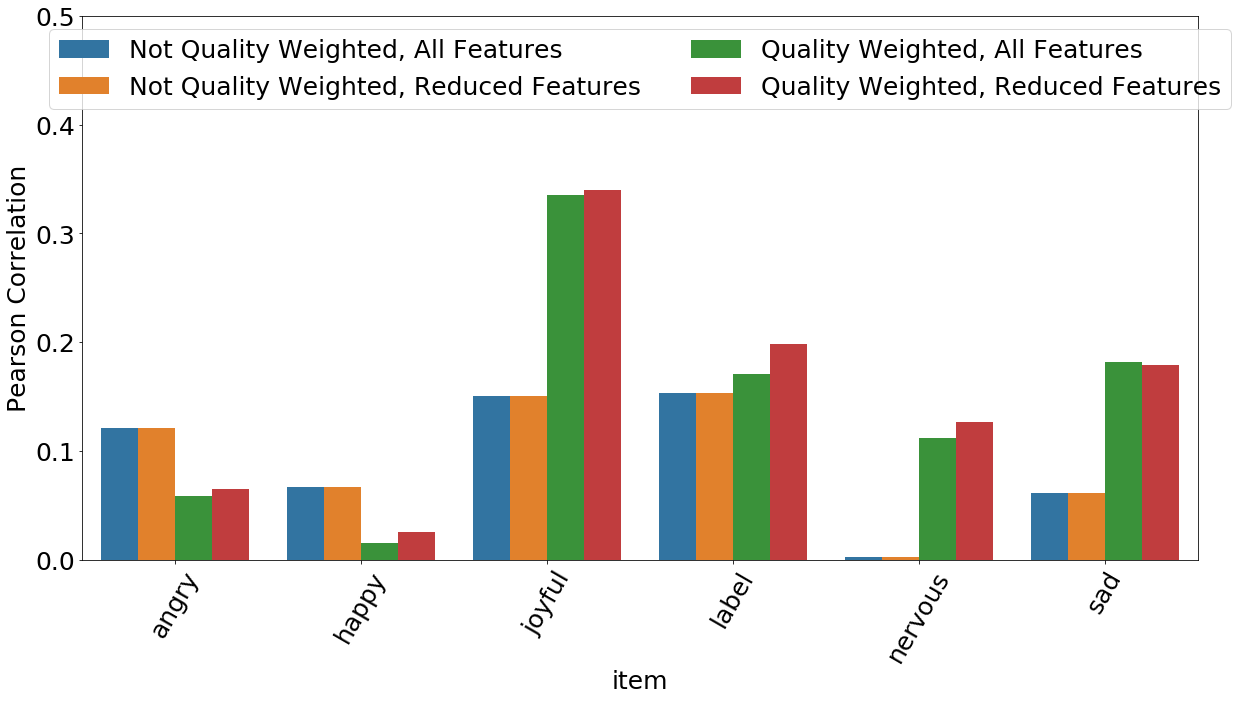

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(20,10))
sns.barplot(x='item',y='f1',hue='type',data=final_results)
plt.legend(loc='upper center',ncol=2)
plt.ylabel('Pearson Correlation')
plt.ylim([0,.5])
plt.xticks(rotation=60)
plt.show()

In [141]:
def get_final_results(df):
    df = df.sort_values('f1').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df
final_results = median_results.groupby(['item'],as_index=False).apply(get_final_results).reset_index(drop=True)

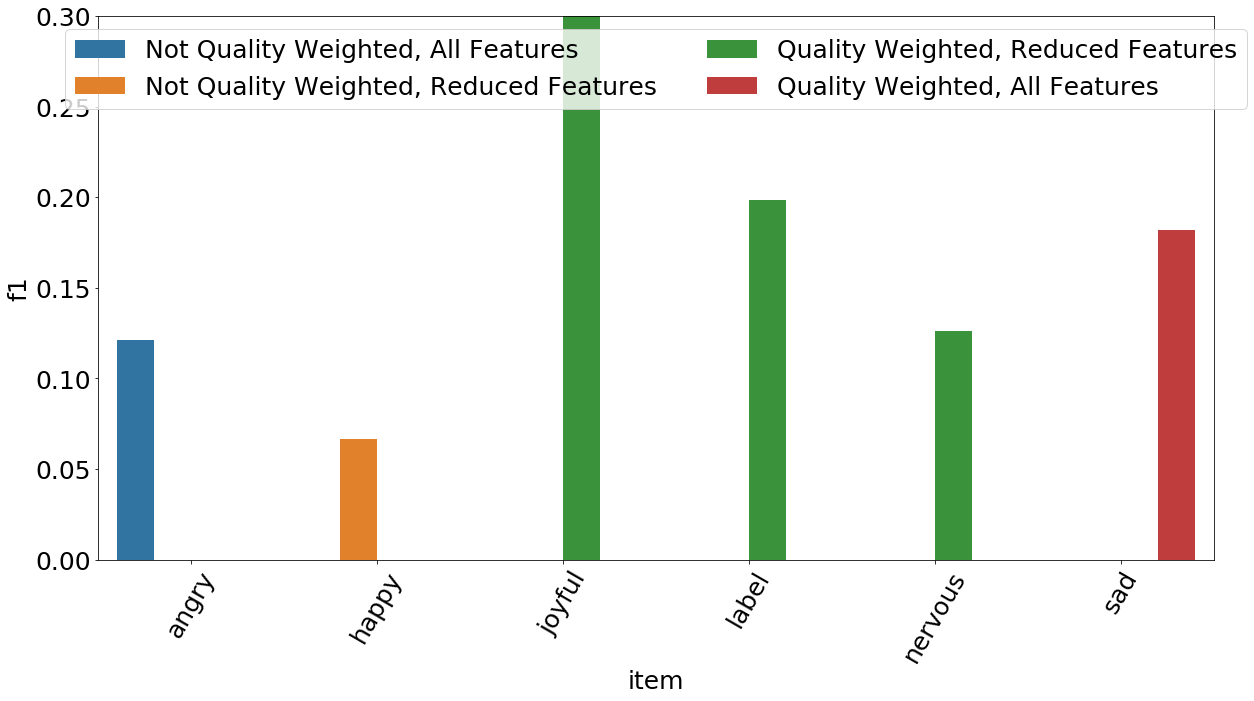

In [142]:
###### import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(20,10))
sns.barplot(x='item',y='f1',hue='type',data=final_results)
plt.legend(loc='upper center',ncol=2)
plt.ylim([0,.3])
plt.xticks(rotation=60)
plt.show()

In [143]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# plt.rcParams.update({'font.size':30})

# df = final_results
# #https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
# fig, ax =plt.subplots(figsize=(20,10))
# ax.axis('tight')
# ax.axis('off')
# the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')
# # plt.show()
# #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
# # pp = PdfPages("foo.png")
# plt.savefig("foo.png", bbox_inches='tight')
# pp.close()
final_results

15551,type,feature,item,shape,scale,auc,f1,conf
0,"Not Quality Weighted, All Features",median,angry,9.75,1.25,0.121326,0.121326,0
1,"Not Quality Weighted, Reduced Features",mean,happy,9.75,7.50,0.066823,0.066823,0
2,"Quality Weighted, Reduced Features",80,joyful,9.25,2.25,0.340200,0.340200,0
3,"Quality Weighted, Reduced Features",80,label,9.75,2.75,0.198387,0.198387,0
4,"Quality Weighted, Reduced Features",median,nervous,9.75,9.75,0.126193,0.126193,0
5,"Quality Weighted, All Features",mean,sad,5.25,3.75,0.181916,0.181916,0


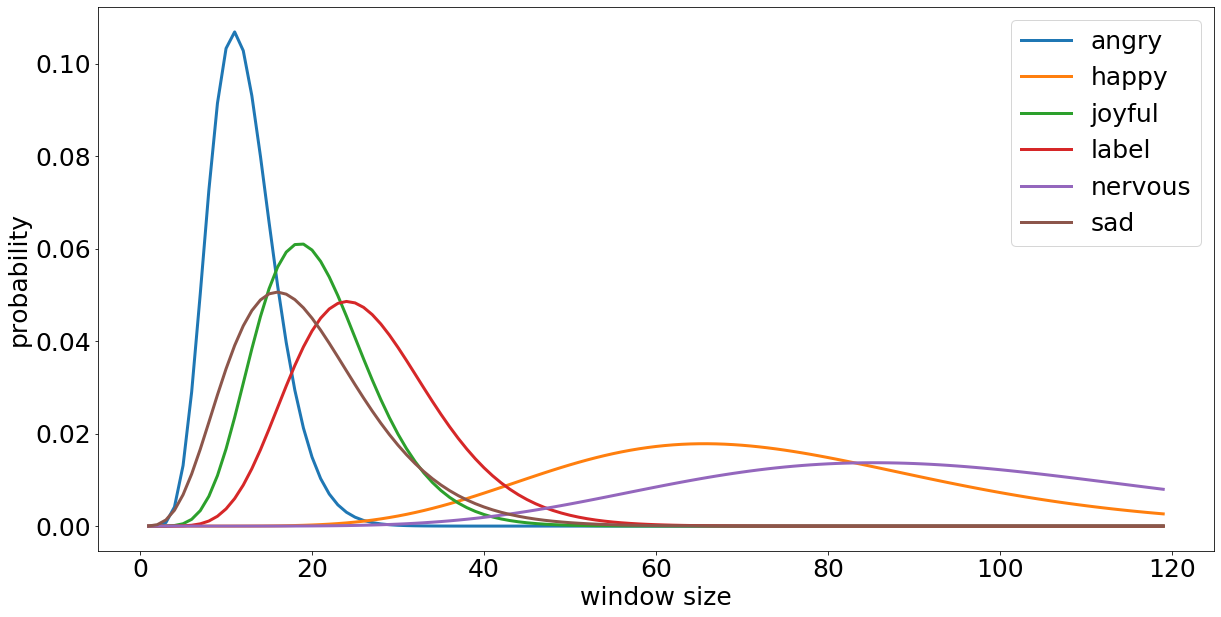

In [144]:
types = ['angry','happy','joyful','label','nervous','sad']
shape = [3.25,6,3.25,5.5,7.25]
scale = [4.75,4,6.25,6,1.5]
shape = final_results['shape'].values
scale = final_results['scale'].values
plt.figure(figsize=(20,10))
for i in range(len(shape)):
    probs = stats.gamma.pdf(np.arange(1,120,1), a=shape[i], scale=np.array(scale)[i])
    plt.plot(np.arange(1,120,1),probs,label=types[i],linewidth=3)
plt.xlabel('window size')
plt.ylabel('probability')
# plt.ylim([0,.2])
plt.legend()
plt.show()
    

In [145]:
import pickle
import numpy as np
import pandas as pd
data = pickle.load(open('data_less_motion_specific.p','rb'))


In [146]:
data= data[data.window_size==30]

In [147]:
data = data[data.feature=='80']

In [148]:
data.shape

(352, 10)

In [149]:
x = []
y = []
users = []
ema_type = []
stress = []
qual = []
labels = ['happy','joyful','nervous','sad','angry','label']
for ema in labels:
    print(ema)
    feature_name_array = ['Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']
    for f in feature_name_array:
        data_ema = data[(data['type']==f)&(data.item==ema)]
        print(data_ema.type.unique(),data_ema.item.unique())
        count = 0
        for user in data_ema.user.unique():
            data_ema_user = data_ema[data_ema.user==user]
            tmp = data_ema_user['probs'].values[0]
            x.extend(list(tmp['y'].values))
            y.extend(list(tmp['y_pred'].values))
            qual.extend(list(tmp['80'].values))
            users.extend([user]*tmp.shape[0])
            ema_type.extend([ema]*tmp.shape[0])
            stress.extend([f]*tmp.shape[0])
            print(tmp.shape[0],end=',')
    print()


happy
['Quality Weighted, Reduced Features'] ['happy']
24,15,14,79,18,12,22,70,22,35,27,23,10,10,28,['Quality Weighted, All Features'] ['happy']
24,15,14,79,18,12,22,70,22,35,27,23,10,10,28,['Not Quality Weighted, Reduced Features'] ['happy']
24,15,14,79,18,12,22,70,22,35,27,23,10,10,28,['Not Quality Weighted, All Features'] ['happy']
24,15,14,79,18,12,22,70,22,35,27,23,10,10,28,
joyful
['Quality Weighted, Reduced Features'] ['joyful']
24,15,14,79,18,12,22,20,70,22,35,27,10,10,28,['Quality Weighted, All Features'] ['joyful']
24,15,14,79,18,12,22,20,70,22,35,27,10,10,28,['Not Quality Weighted, Reduced Features'] ['joyful']
24,15,14,79,18,12,22,20,70,22,35,27,10,10,28,['Not Quality Weighted, All Features'] ['joyful']
24,15,14,79,18,12,22,20,70,22,35,27,10,10,28,
nervous
['Quality Weighted, Reduced Features'] ['nervous']
24,15,14,79,18,12,72,22,70,35,27,45,23,10,['Quality Weighted, All Features'] ['nervous']
24,15,14,79,18,12,72,22,70,35,27,45,23,10,['Not Quality Weighted, Reduced Feature

In [150]:
data = pd.DataFrame({'EMA zscore':x,'Stress 80th Percentile':y,'user':users,'EMA item':ema_type,'Stress pathway':stress,'Quality':qual})

In [151]:
data.dropna().shape,data.shape

((10692, 6), (10692, 6))

(466, 6)


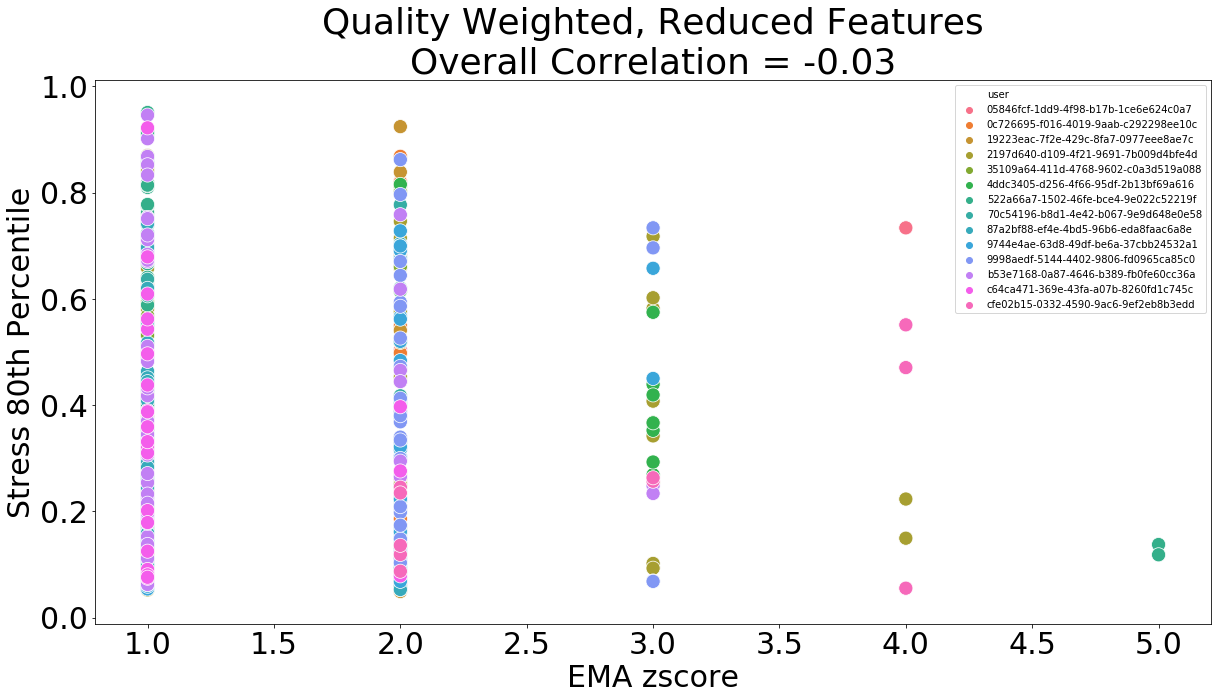

[0.45119381150588306, 0.17998356304225968, 0.15971230873471975, 0.03190622742886101, 0.19422878138124486, -0.19195634656642288, -0.1714503476213917, -0.5731248298941215, -0.1723369590178124, 0.36022766861375094, 0.004212801533943003, -0.11230195731074666, -0.1671001723954283] 0.004212801533943003
(466, 6)


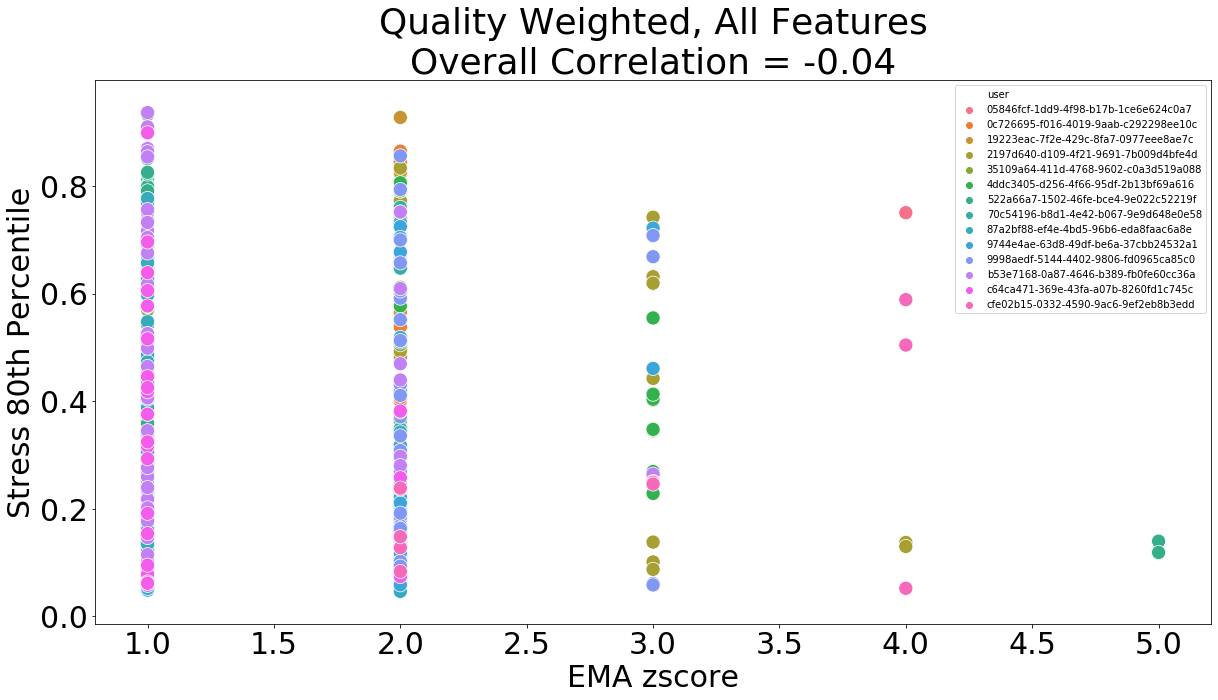

[0.44854851236313675, 0.17582079102684778, 0.22028682458661455, 0.024166432154371444, 0.15600653060549025, -0.2334627891464569, -0.16893944031974933, -0.5469268963328473, -0.17669925508353365, 0.3777955416648641, -0.023078293761609844, -0.10359462770037539, -0.184837110067951] -0.023078293761609844
(466, 6)


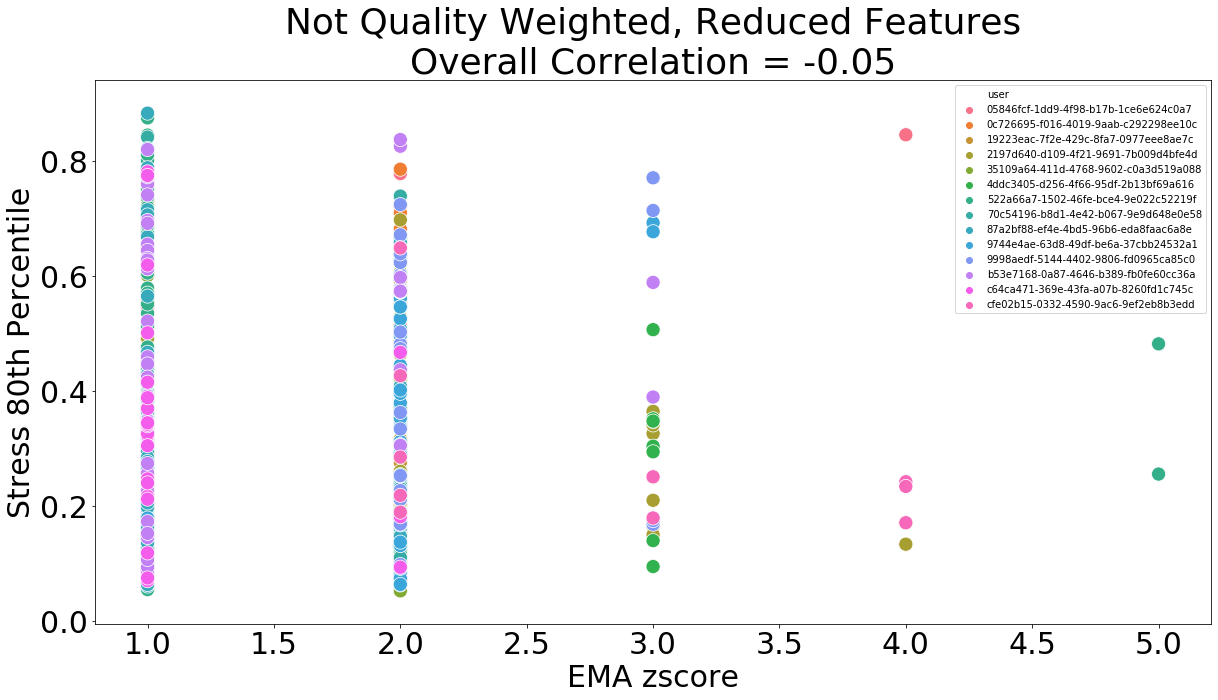

[0.411871132136962, -0.0668254208190035, 0.031202574962348056, -0.18434564748010612, 0.3009548211990353, -0.005384660046248574, -0.04708280299766912, -0.32812900023388236, -0.14779841330693144, 0.4149542282493628, 0.037453987746288483, 0.21977553037707342, -0.18121064028567238] -0.005384660046248574
(466, 6)


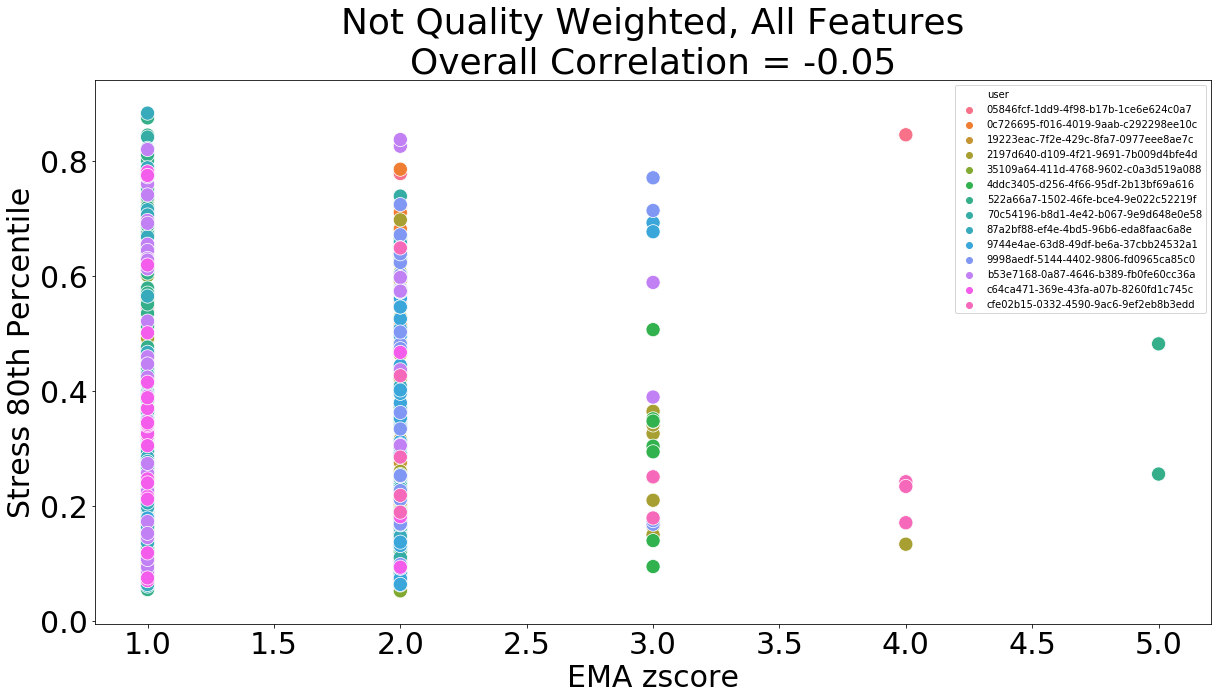

[0.411871132136962, -0.0668254208190035, 0.031202574962348056, -0.18434564748010612, 0.3009548211990353, -0.005384660046248574, -0.04708280299766912, -0.32812900023388236, -0.14779841330693144, 0.4149542282493628, 0.037453987746288483, 0.21977553037707342, -0.18121064028567238] -0.005384660046248574


In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_name_array = ['Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']
for f in feature_name_array:
    tmp = data[(data['EMA item']=='nervous')&(data['Stress pathway']==f)]
#     print(tmp.shape)
    # for user in tmp1.user.unique():
    #     tmp = tmp1[tmp1.user==user]
    plt.rcParams.update({'font.size':30})
    plt.figure(figsize=(20,10))
    sns.scatterplot(x='EMA zscore',y='Stress 80th Percentile',data=tmp,hue='user',s=200)
#     corrs = [pearsonr(df['EMA zscore'],df['Stress 80th Percentile'])[0] for i,df in tmp.groupby('user')]
#     print(np.median(corrs))
    print(tmp.shape)
    plt.title(f+'\n'+"Overall Correlation = "+"{:.2f}".format(pearsonr(tmp['EMA zscore'],tmp['Stress 80th Percentile'])[0]))
    plt.legend(fontsize=10)
    plt.savefig('joyful'+f+'.png')
    plt.show()
#     tmp['Quality'] = tmp['Quality'].apply(lambda a:np.round(10*a)/10)
    corrs = [pearsonr(df['EMA zscore'],df['Stress 80th Percentile'])[0] for i,df in tmp.groupby(['user']) if df.shape[0]>10]
    
#     for q in np.arange(0,1,.1):
#         tmp1 = tmp[tmp['Quality']>=q]
#         print(q,pearsonr(tmp1['EMA zscore'],tmp1['Stress 80th Percentile'])[0],tmp1.shape)
    print(corrs,np.median(corrs))

In [ ]:
logit=df

In [ ]:
logit.head()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def get_data(df):
    all_rows = []
    for i,row in df.iterrows():
        for j,row1 in row['probs'].iterrows():
            all_rows.append([row['type'],row['feature'],row['user'],row['window_size'],row['auc'],row['f1'],row['corr'],
                            row1['mean'],row1['80'],row1['20'],row1['y'],row1['y_pred']])
    return pd.DataFrame(all_rows,columns=['type','feature','user','window_size','auc','f1','corr','mean','80','20','y','y_pred'])

logit_data = logit.groupby(['type','window_size','feature'],as_index=False).apply(get_data)
from copy import deepcopy
print(logit_data.shape)
df1 = deepcopy(logit_data)
df1['y'] = np.int64(df1['y'].values)
df1['y_pred'] = np.float64(df1['y_pred'].values)
df1['indicator'] = 1
df1['indicator'][(df1.y==0)&(df1.y_pred==0)] = 'Not Stress - Not Stress'
df1['indicator'][(df1.y==0)&(df1.y_pred==1)] = 'Not Stress - Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==0)] = 'Stress - Not Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==1)] = 'Stress - Stress'

In [ ]:
df1 = df1.reset_index(drop=True)

In [ ]:
df1['80'] = df1['80'].apply(lambda a: a if a<.95 else .95)
df1['20'] = df1['20'].apply(lambda a: a if a<.95 else .95)

In [ ]:
df1.info()

In [ ]:
df1['mean_round'] = np.floor((df1['80']*100)//10)/10
df1['20'] = df1['20'].apply(lambda a:a if a<=1 else a/2)
df1['mean_quality'] = np.floor((df1['20']*100)//10)/10

In [ ]:
df1.mean_quality.unique()

In [ ]:
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,balanced_accuracy_score
def merge_e(df1):
    names = ['var','iqr','mean','median','80','20','max']
    if df1.shape[0]<10:
        return pd.DataFrame([],columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
    df1 = df1.reset_index(drop=True)
#     try:
    df_col = []
    for qual in df1['mean_quality'].unique():
        df = df1[df1.mean_quality>=qual]
        if df.shape[0]<10:
            continue
        temp_df = pd.DataFrame([[
                  df['type'].values[0],
                  df['feature'].values[0],
                  df['mean_round'].values[0],
                  qual,
                  df['window_size'].values[0],
                  balanced_accuracy_score(df['y'],df['y_pred']),
                  roc_auc_score(df['y'],df['y_pred']),
                  100*np.float64(df.shape[0])/df1.shape[0],
                  df['user'].values[0]]],
                  columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
        df_col.append(temp_df)
    if len(df_col)>0:
        return pd.concat(df_col)
    else:
        return pd.DataFrame([],columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
    
#     except:
#         return pd.DataFrame([],columns=['feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
# df2 = df1.groupby(['mean_round','window_size','mean_quality','feature'],as_index=False).apply(merge_e)
# df2_aux = df1.groupby(['mean_round','window_size','feature'],as_index=False).apply(merge_e)
df2_qual = df1.groupby(['window_size','feature','type'],as_index=False).apply(merge_e)
# df2_aux_best = df1.groupby(['mean_round','window_size','feature'],as_index=False).apply(merge_e)
# df2_qual_best = df1.groupby(['window_size','mean_quality','feature'],as_index=False).apply(merge_e)
# df2

In [ ]:
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def groupby_df(df):
    feature = df.feature.values[0]
    types = df['type'].values[0]
    qual = df['qual'].values[0]
    probs = []
    accs = []
    for i,row in df.iterrows():
        prob = probs_final[row['window_size']]
        probs.append(prob)
        accuracy = row['roc_auc']
        accs.append(accuracy)
    final_acc,final_std = weighted_avg_and_std(accs, probs)
    size = df['size'].mean()
    data = [[feature,types,qual,final_acc,size,final_std,"{:.2f}".format(final_acc)+', '+"{:.2f}".format(final_std)]]
    return pd.DataFrame(data,columns=['feature','type','qual','roc_auc','size','std','show'])
        
from scipy import stats
windows = np.arange(10,65,5)
probs = stats.gamma.pdf(windows, a=3.8, scale=5)
probs_final = {windows[i]:probs[i] for i in range(len(windows))}
df3_qual = df2_qual.groupby(['feature','type','qual'],as_index=False).apply(groupby_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':30})
# sns.barplot(x='qual',y='size',data=df3_qual[df3_qual.feature=='Logistic Regression'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')

# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df3_qual[df3_qual.feature=='Logistic Regression'],linewidth=4)
plt.xlabel(r'$q_{w}$')
plt.ylabel('ROC AUC SCORE')
axy = plt.gca().twinx()
# axy.scatter(df3_qual[df3_qual.feature=='Logistic Regression']['qual'],df3_qual[df3_qual.feature=='Logistic Regression']['roc_auc'],c = df3_qual[df3_qual.feature=='Logistic Regression']['type'])
axy.bar(df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['qual'].values,
        df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['size'].values,.05,alpha=.2)
axy.set_ylabel('Percentage of EMAs Remaining')
plt.legend(loc='upper center',ncol=4)

plt.savefig('Logistic_regression.png')
plt.savefig('Logistic_regression.pdf')
# axy.ylim([.65,.82])
# sns.barplot(x='feature',y='size',data=df2_qual[df3_qual.feature=='Logistic Regression'],ax=axy)
plt.show()

In [ ]:
df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['size']

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(18,10))
# plt.plot(df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['qual'].values,
#          df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['roc_auc'].values)
# plt.show()
print(df2_qual['feature'].unique())

# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# # print(df1.shape,df2.shape)
# plt.rcParams.update({'font.size':20})

df3_qual = df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean','Logistic Regression'])]
plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.savefig('qr1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, All Features')
plt.legend(ncol=5)
plt.savefig('qa1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Not Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Not Quality Weighted, All Features')
plt.legend(ncol=5)
plt.ylim([.54,.79])
plt.savefig('nqa1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Not Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Not Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.ylim([.54,.79])
plt.savefig('nqr1.png')
plt.show()



In [ ]:
sns.set(font_scale=2)
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('qr.png',bbox_inches='tight')
plt.show()
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('nqr.png',bbox_inches='tight')
plt.show()
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('nqa.png',bbox_inches='tight')
plt.show()

a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('qa.png',bbox_inches='tight')
plt.show()


# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()

# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='size',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# # plt.figure(figsize=(20,10))
# # sns.heatmap(pd.pivot_table(df2,index='qual',columns='aux',values='size',aggfunc='median'),annot=True,cmap="Reds",fmt='g')
# # plt.show()
# # # df2.groupby('mean_qual').mean()
# # # df2.info()
# # df2_qual.groupby('qual').count()

In [ ]:
df3_qual[df3_qual.type=='Not Quality Weighted, Reduced Features'].feature.unique()

In [ ]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(35,10))
with sns.axes_style('white'):
    ax = sns.heatmap(np.random.rand(6,10)*1, annot=a.values, fmt="",cmap=ListedColormap(['white']),linewidth=5)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.show()

In [ ]:
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
plt.figure(figsize=(16,8))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, a)  # where df is your data frame

plt.savefig('Not Quality Weighted,ReducedFeatures.pdf',bbox_inches='tight')
plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandas.tools.plotting import table
# import numpy as np

# dates = pd.date_range('20130101',periods=6)
# df = a

# df.index = [item.strftime('%Y-%m-%d') for item in df.index] # Format date

# fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
# tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
# tabla.scale(1.2, 1.2) # change size table
# plt.savefig('table.png', transparent=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(a, df)  # where df is your data frame

# plt.savefig('mytable.png')
# plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandas.tools.plotting import table
# import numpy as np

# dates = pd.date_range('20130101',periods=6)
# df = a

# df.index = [item.strftime('%Y-%m-%d') for item in df.index] # Format date

# fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
# tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
# tabla.scale(1.2, 1.2) # change size table
# plt.savefig('table.png', transparent=True)

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.barplot(x='qual',y='roc_auc',hue='type',data=df4_qual,linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])
plt.show()
# df2_qual[df2

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.barplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='Logistic Regression'],linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])
plt.show()
# df2_qual[df2_qual.feature=='Logistic Regression']

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='window_size',data=df2_qual[(df2_qual.feature=='Logistic Regression')&(df2_qual['type']=='Quality Weighted, Reduced Features')],linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])

In [ ]:
# import matplotlib.pyplot as plt
df2_qual = df2_qual[df2_qual.window_size==20].sort_values('qual').reset_index(drop=True)
# plt.figure(figsize=(18,10))
# plt.plot(df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['qual'].values,
#          df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['roc_auc'].values)
# plt.show()
print(df2_qual['feature'].unique())

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})


plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df2_qual[df2_qual['type']=='Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df2_qual[df2_qual['type']=='Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, All Features')
plt.legend(ncol=5)
plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})

plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='Logistic Regression'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='max']['qual'],df2_qual[df2_qual.feature=='max']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Maximum')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='max'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='80']['qual'],df2_qual[df2_qual.feature=='80']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = 80th Percentile')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='80'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='median']['qual'],df2_qual[df2_qual.feature=='median']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Median')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='median'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='mean']['qual'],df2_qual[df2_qual.feature=='mean']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Mean')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='mean'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='20']['qual'],df2_qual[df2_qual.feature=='20']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = 20th Percentile')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='20'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()
# plt.figure(figsize=(20,10))
# sns.barplot(x='qual',y='roc_auc',hue='feature',data=df2_qual_best,linewidth=4)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='qual',y='size',data=df2)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.barplot(x='aux',y='roc_auc',data=df2_aux_best,linewidth=4)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>50)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>100)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>0)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>150)])
# plt.legend(ncol=5)
# plt.show()
# df2.reset_index(drop=True).pivot('mean_qual','mean_aux','roc_auc')
# plt.figure(figsize=(20,10))
# sns.heatmap(pd.pivot_table(df2,index='qual',columns='feature',values='roc_auc',aggfunc='mean'),annot=True,cmap="YlGnBu")
# plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='size',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
# plt.figure(figsize=(20,10))
# sns.heatmap(pd.pivot_table(df2,index='qual',columns='aux',values='size',aggfunc='median'),annot=True,cmap="Reds",fmt='g')
# plt.show()
# # df2.groupby('mean_qual').mean()
# # df2.info()
# df2_qual.groupby('qual').count()

In [ ]:
print(df['user'].unique().shape)
df1 = df.groupby(['type','feature','window_size'],as_index=False).median()

In [ ]:
def get_max_auc(df):
    df = df.sort_values('auc').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df

some_data = df1.groupby(['feature','type'],as_index=False).apply(get_max_auc)

In [ ]:
some_data

In [ ]:
tt = df1.groupby(['type','feature','window_size'],as_index=False).max().sort_values('auc').reset_index(drop=True)

In [ ]:
plt.figure(figsize=(18,20))
plt.rcParams.update({'font.size':20})
sns.barplot(x='feature',y='auc',hue='type',data=tt)
plt.xticks(rotation=10)
plt.legend(ncol=2)

In [ ]:
tt1 = tt[(tt.feature=='Logistic Regression')&(tt['type']=='Quality Weighted, Reduced Features')].sort_values('auc').reset_index(drop=True)
tt1

In [ ]:
plt.figure(figsize=(18,10))
sns.barplot(x='window_size',y='auc',data=tt1)
plt.title('AUC score in different window sizes for Logistic Regression Model')
plt.xticks(rotation=50)

In [ ]:
some_data = some_data[some_data['type']=='Quality Weighted, All Features'].sort_values('auc').reset_index(drop=True)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,10))
plt.bar(some_data['feature'],some_data['auc'],.5)
plt.ylabel('Median F1')
plt.xticks(range(some_data.shape[0]),[row['feature']+'\n'+str(row['window_size'])+' minutes' for i,row in some_data.iterrows()],rotation=60)
plt.show()

In [ ]:
plt.figure(figsize=(18,10))
# df2['index'] = 
sns.barplot(x='user',y='auc',data=df[(df.feature=='Logistic Regression')&(df.window_size==10)&(df['type']=='Quality Weighted, All Features')].sort_values('auc'))
plt.hlines(.5,0,15)
plt.hlines(.668,0,15,color='r')
plt.title('Logistic Regression Best Model Performance, across all users')
plt.xticks([])
# plt.legend(ncol=10)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

In [ ]:
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and precision[i]>recall[i]-.1:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)    

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [10,1,100,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[True]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b,'rr')
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred),confusion_matrix(y,y_pred))
#     clf.fit(X,y)
    return np.array([f1_score(y,y_pred),roc_auc_score(y,y_pred),recall_score(y,y_pred)])

In [ ]:
def get_user_results(df):
    print(df['duration'].unique())
    qual = df['q'].values[0]
    groups = np.array(list(df['user']))
    X = np.array(list(df['feature']))
    y = np.array(list(df['label']))
    duration = df['duration'].values[0]
    print(duration,qual)
    arr = get_results(X,y,groups)
    return pd.DataFrame([[duration,qual,arr[0],arr[1],arr[2]]],columns=['duration','quality','f1','precision','recall'])

In [ ]:
import numpy as np
def get_results_qual(data_global,q):
    data_global1 = deepcopy(data_global[data_global.quality>=q]).reset_index(drop=True)
    print(data_global1['duration'].unique())
    print(data_global1.shape,data_global.shape)
    data_global1['q'] = q
    data_d = data_global1.groupby('duration',as_index=False).apply(get_user_results)
    return data_d
from joblib import Parallel,delayed
# all_data = Parallel(n_jobs=-1,verbose=3)(delayed(get_results_qual)(data_global,q) for q in np.arange(0,.5,.05))
all_data = [get_results_qual(data_global,q) for q in np.arange(0,.5,.05)]

In [ ]:
results = pd.concat(all_data)

In [ ]:
results.groupby('quality').max()

In [ ]:
import statsmodels

In [ ]:
directory_ema = '../../cc3/rice_data/ecg_ppg_ema_final/'

In [ ]:
import os

import pickle

In [ ]:
import os
import pickle
import pandas as pd
from sklearn.metrics import cohen_kappa_score
directory_ema = '../../cc3/rice_data/ecg_ppg_ema_final/'

def corr_matrix(numeric_df):
    cols = numeric_df.columns
    idx = cols.copy()
    mat = numeric_df.values
    mat = np.int64(mat).T
    K = len(cols)
    correl = np.empty((K, K), dtype=float)
    for i, ac in enumerate(mat):
        for j, bc in enumerate(mat):
            correl[i, j] = cohen_kappa_score(ac,bc,labels=[0,1])
            correl[j, i] = cohen_kappa_score(ac,bc)
    return pd.DataFrame(correl,index=idx, columns=cols)

all_mat = []
for f in os.listdir(directory_ema):
    ema = pickle.load(open(directory_ema+f,'rb'))
    ema = ema.sort_values('score').reset_index(drop=True)
    if ema.shape[0]<15:
        continue
    def get_sign(s,reverse=False):
        if not reverse:
            negative = 0
            positive = 1
        else:
            negative = 1
            positive = 0
        if s<=0:
            return negative
        else:
            return positive
    ema['happy'] = ema['all_scores'].apply(lambda a:a[0])
    ema['joyful'] = ema['all_scores'].apply(lambda a:a[1])
    ema['nervous'] = ema['all_scores'].apply(lambda a:a[2])
    ema['sad'] = ema['all_scores'].apply(lambda a:a[3])
    ema['angry'] = ema['all_scores'].apply(lambda a:a[4])
    happy,joy,nervous,sad,angry = ema['happy'].mean(),ema['joyful'].mean(),ema['nervous'].mean(),ema['sad'].mean(),ema['angry'].mean()
    ema['happy'] = ema['happy'].apply(lambda a:get_sign(a-happy,False))
    ema['joyful'] = ema['joyful'].apply(lambda a:get_sign(a-joy,False))
    ema['nervous'] = ema['nervous'].apply(lambda a:get_sign(a-nervous))
    ema['sad'] = ema['sad'].apply(lambda a:get_sign(a-sad))
    ema['angry'] = ema['angry'].apply(lambda a:get_sign(a-angry))
    ema = ema[['happy','joyful','sad','angry','nervous']]
    check = False
    for i in range(ema.values.shape[1]):
        if len(np.unique(ema.values[:,i]))==1:
            check=True
#     print(np.unique(ema.values,axis=0))
    if check:
        continue
    print(cohen_kappa_score(ema['happy'],ema['joyful']),)
    kappa_mat = corr_matrix(ema).values
    print(kappa_mat)
    all_mat.append(kappa_mat.reshape(-1,5,5))

In [ ]:
data = np.concatenate(all_mat)

In [ ]:
mean_data = np.nanmean(data,axis=0)
std_data = np.nanstd(data,axis=0)

In [ ]:
# a = np.empty((5, 5), dtype=str)
df = pd.DataFrame(np.empty((5, 5), dtype=str),index=['happy','joyful','sad','angry','nervous'],columns=['happy','joyful','sad','angry','nervous'])

In [ ]:
cols = ['happy','joyful','sad','angry','nervous']
for i,c1 in enumerate(cols):
    for j,c2 in enumerate(cols):
        df.loc[c1,c2] = "{:.2f}".format(mean_data[i,j])+'$\pm$'+"{:.2f}".format(std_data[i,j])

In [ ]:
show = df

In [ ]:
data = pd.DataFrame(mean_data,index=['happy','joyful','sad','angry','nervous'],columns=['happy','joyful','sad','angry','nervous'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.heatmap(data,annot=show,fmt='',cmap='Reds',cbar=False,linewidth=1,linecolor='black')
plt.yticks(rotation=0)
plt.show()

In [ ]:
fleiss_kappa(np.round(np.abs(np.random.uniform(0,1,(10,2)))))

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
cohen_kappa_score(np.round(np.abs(np.random.uniform(0,1,(10,2))))[:,0],np.round(np.abs(np.random.uniform(0,1,(10,2))))[:,1])